# YOLO Couple thoughts on safety issue - data verification and preparation

## Prerequisites

Import of the necessary modules

In [1]:
# basic
import numpy as np
import pandas as pd

# files' source 
import os
import os.path
import glob
import shutil
import dill

# images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

# xmls
from lxml import etree
import re

# for models
from sklearn.model_selection import train_test_split 

## Dataset review

The structure of source data folder
```
-helmet
    --annotations
    --images
```

In [2]:
# path to source data from https://www.kaggle.com/andrewmvd/hard-hat-detection (1,23GB!!!)
base_folder = ''
# path to dir with data for models
model_folder = ''

images_path = os.path.join(base_folder, 'images')
annots_path = os.path.join(base_folder, 'annotations')

Sample image

4025: hard_hat_workers4025.png, hard_hat_workers4025.xml


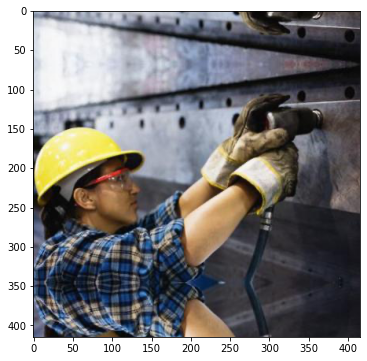

In [3]:
no_img = int(np.random.randint(0, 4999, 1))
images_name = 'hard_hat_workers' + str(no_img) + '.png'
annots_name = 'hard_hat_workers' + str(no_img) + '.xml'

print(f'{no_img}: {images_name}, {annots_name}')

plt.figure(figsize = (6,6))
img = mpimg.imread(os.path.join(images_path, images_name))
plt.imshow(img)
plt.show()

In [4]:
# Własny parser xml
# (żeby wyjąć tylko potrzebne informacje w formie wymaganej do wstępnej analizy; 
# najprowdopodobniej będzie trzeba to zmienć do formatu YOLO)

def parseXML(xml_file):
    """
    Parse the xml - annotation for images
    
    _ARGS
    xml_file: str    source of xml file (path) 
    
    _OUTPUTS
    dict_size: List  list of dict with information about image sizes
    dict_obj: List   list of dict with information for bounding boxes
    """
    with open(xml_file) as fobj:
        xml = fobj.read()

    root = etree.fromstring(xml)
    
    # number of img
    no = re.findall(r'[0-9]+', root.getchildren()[1].text)[0]
    
    # size
    dict_size ={}
    for obj in [x for x in root.getchildren() if x.tag == 'size']:
        for child in list(obj):
            dict_size[child.tag] = int(child.text)
            
    ls_size.append({**{'no': no}, **dict_size})

    # annotation        
    i = 0
    for obj in [x for x in root.getchildren() if x.tag == 'object']:
        for child in list(obj):
            dict_box = {}
            dict_base = {}

            if child.tag == 'name':
                lbl = child.text

            if child.tag == 'bndbox':
                for elem in child:
                    dict_box[elem.tag] = int(elem.text)

            dict_base = {'no': int(no),
                         'no_i':i,
                         'lbl':lbl}

        ls_obj.append({**dict_base, **dict_box})
        i += 1

Base object along with information about dataset

In [5]:
ls_size = []
ls_obj = []

for f_xml in os.listdir(annots_path):
    parseXML(os.path.join(annots_path, f_xml))

## Analysis of information from xml

In [6]:
tab_size = pd.DataFrame(ls_size)
tab_size = tab_size.iloc[tab_size['no'].astype(int).argsort()]
tab_size.shape, tab_size.columns

((5000, 4), Index(['no', 'width', 'height', 'depth'], dtype='object'))

In [7]:
tab_size['no'].nunique()

5000

<u>CONCLUSION</u> the table contains information about the size for all images.

In [8]:
tab_size['depth'].value_counts()

3    5000
Name: depth, dtype: int64

<u>CONCLUSION</u> All images are coloured - number of channels 3 (RGB)

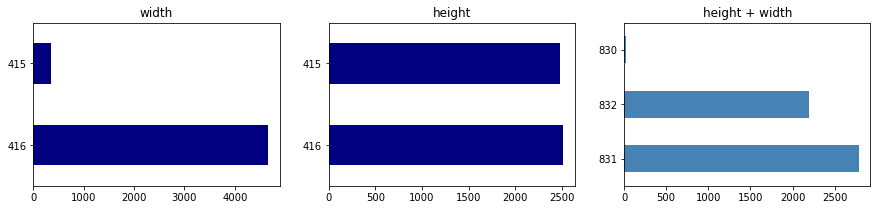

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

tab_size['width'].value_counts().plot.barh(color='navy', ax=ax[0])
ax[0].set_title('width')

tab_size['height'].value_counts().plot.barh(color='navy', ax=ax[1])
ax[1].set_title('height')

tab_size[['height', 'width']].sum(axis=1).value_counts().plot.barh(color='steelblue', ax=ax[2])
ax[2].set_title('height + width');

<u>CONCLUSION</u> There are three image sizes: 415x415, 416x415 and 415x416.

In [10]:
tab_obj = pd.DataFrame(ls_obj).sort_values(by=['no', 'no_i'])
tab_obj.shape, tab_obj.columns

((25502, 7),
 Index(['no', 'no_i', 'lbl', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object'))

In [11]:
tab_obj['no'].nunique()

5000

<u>CONCLUSION</u> The table contains information about the bounding box for all images.

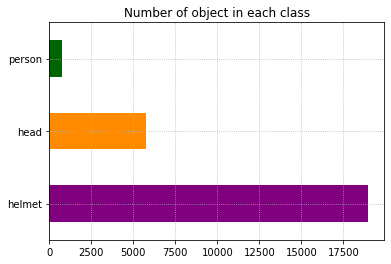

In [12]:
tab_obj['lbl'].value_counts().plot.barh(color= ['purple', 'darkorange', 'darkgreen'])
plt.grid(ls=':')
plt.title('Number of object in each class');

In [13]:
tab_obj.groupby(['no'])['lbl'].nunique().value_counts()

1    4359
2     623
3      18
Name: lbl, dtype: int64

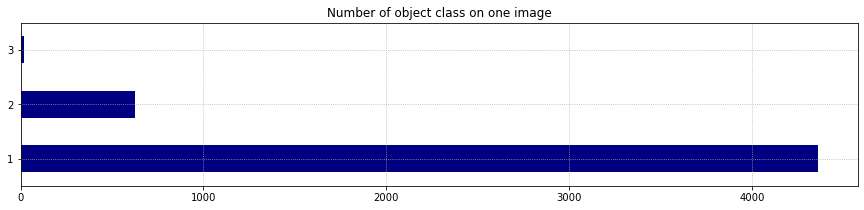

In [14]:
plt.figure(figsize=(15,3))
tab_obj.groupby(['no'])['lbl'].nunique().value_counts().plot.barh(color='navy')
plt.grid(ls=':')
plt.title('Number of object class on one image');

In [15]:
ls_tab = [tab_obj, tab_size]

In [16]:
with open("ls_tab.pkl", "wb") as file:
    dill.dump(ls_tab, file)

## Interesting samples of images

In [17]:
from data.object.myfunctions import showIMG

Image with max number of bounding box on an image (68)

4767: hard_hat_workers4767.png


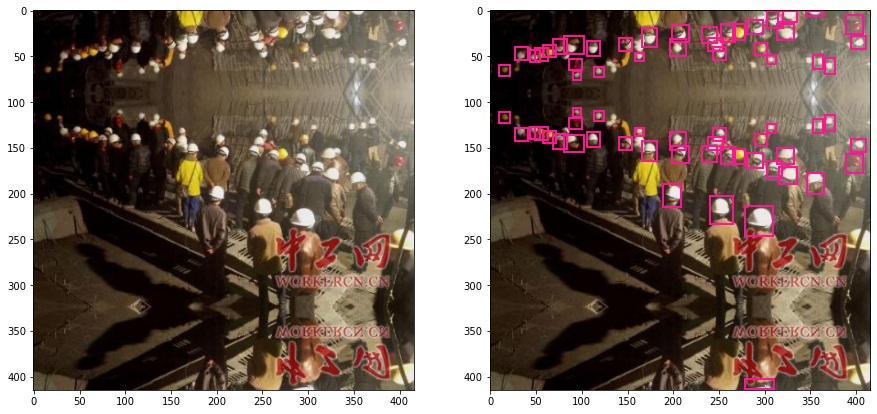

In [18]:
showIMG(no_image=4767, img_path=images_path, tab_bndbox=tab_obj)

In [19]:
tab_no_lbl = pd.pivot_table(data = tab_obj, index='no', \
                            aggfunc={'lbl':pd.Series.nunique}, fill_value=0)
ls_lbl_3 = tab_no_lbl[tab_no_lbl['lbl'] == 3].index.values.tolist()

tab_len_lbl = pd.pivot_table(data = tab_obj[tab_obj['no'].isin(ls_lbl_3)], index='no', \
                             aggfunc={'lbl':len}, fill_value=0)
tab_len_lbl['lbl'].idxmax()

857

Image with max number of bounding boxes with all classes (*head*, *helmet*, *person*)

857: hard_hat_workers857.png


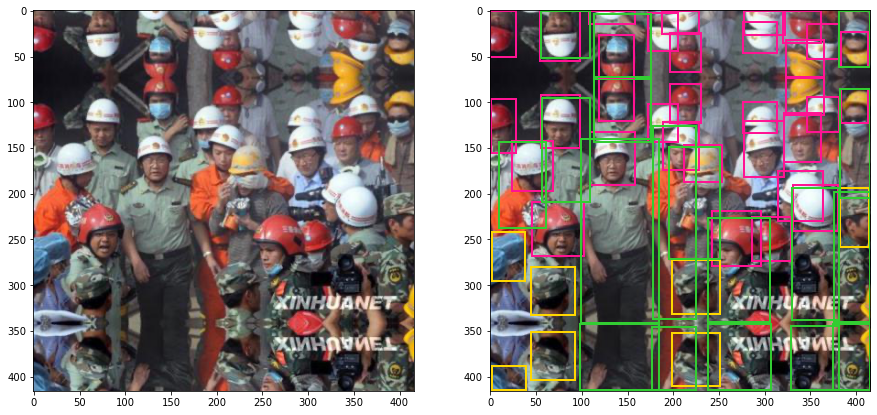

In [20]:
showIMG(no_image=857, img_path=images_path, tab_bndbox=tab_obj)

1006: hard_hat_workers1006.png


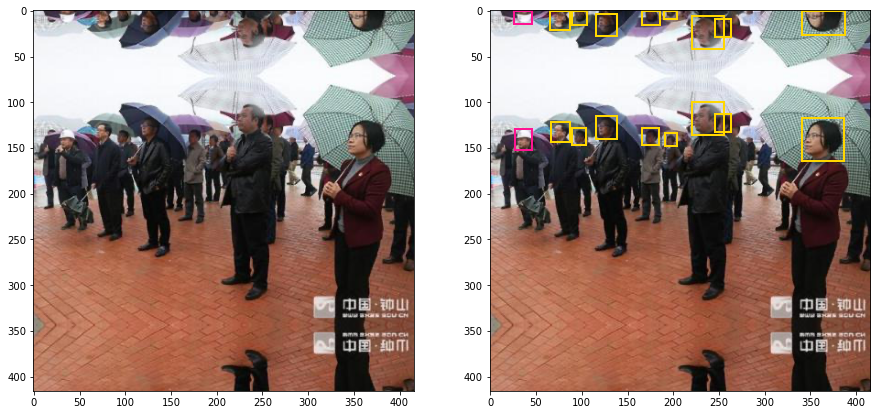

In [21]:
showIMG(no_image=1006, img_path=images_path, tab_bndbox=tab_obj)

Random

4025: hard_hat_workers4025.png


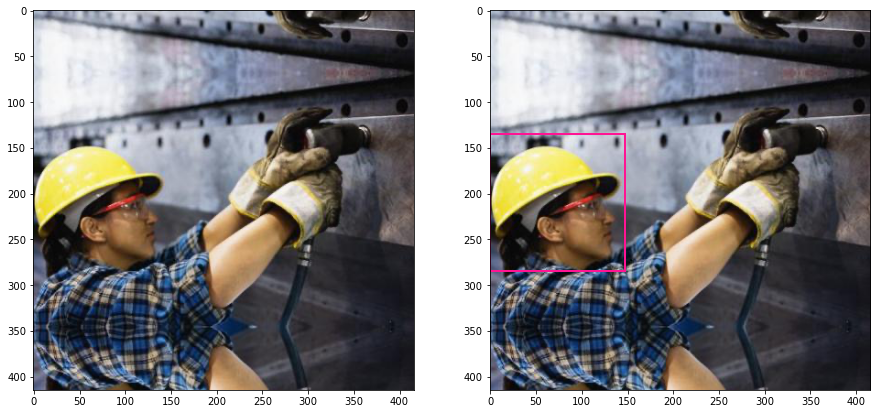

In [22]:
showIMG(no_image=no_img, img_path=images_path, tab_bndbox=tab_obj)

## Train-test split

### Train-test split for 3 labels

In [23]:
tab_nlbl_3 = pd.pivot_table(tab_obj, index = ['no'], aggfunc={'lbl':lambda x: len(x.unique())}, \
                            fill_value=0).rename(columns={'lbl':'num_of_class'})
tab_nlbl_3['num_of_class'].value_counts()

1    4359
2     623
3      18
Name: num_of_class, dtype: int64

In [24]:
train, test = train_test_split(tab_nlbl_3, test_size=0.1, \
                               stratify=tab_nlbl_3['num_of_class'], random_state=42) 

In [25]:
train['num_of_class'].value_counts(), test['num_of_class'].value_counts()

(1    3923
 2     561
 3      16
 Name: num_of_class, dtype: int64,
 1    436
 2     62
 3      2
 Name: num_of_class, dtype: int64)

In [26]:
len(train), len(test)

(4500, 500)

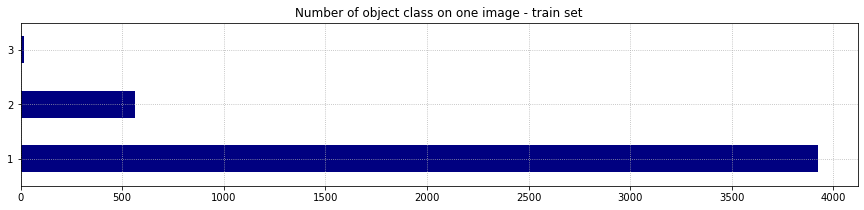

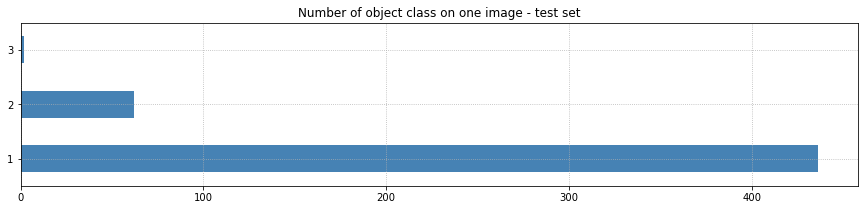

In [27]:
plt.figure(figsize=(15,3))
train['num_of_class'].value_counts().plot.barh(color='navy')
plt.grid(ls=':')
plt.title('Number of object class on one image - train set');
plt.figure(figsize=(15,3))
test['num_of_class'].value_counts().plot.barh(color='steelblue')
plt.grid(ls=':')
plt.title('Number of object class on one image - test set');

In [28]:
ls_img_train = [int(x) for x in train.index]
ls_img_test = [int(x) for x in test.index]

In [29]:
tab_obj[tab_obj['no'].isin(ls_img_train)].shape, tab_obj[tab_obj['no'].isin(ls_img_test)].shape

((22819, 7), (2683, 7))

### Train-test split for 2 labels

Checking if removing the *person* label will reduce the number of images (is there any files that have only object of *person* class?)

In [30]:
tab_obj[tab_obj['lbl'].isin(['head', 'helmet'])]['no'].nunique()

5000

In [31]:
tab_nlbl_2 = pd.pivot_table(tab_obj[tab_obj['lbl'].isin(['head', 'helmet'])], index = ['no'], \
                            aggfunc={'lbl':lambda x: len(x.unique())},  fill_value=0).rename(columns={'lbl':'num_of_class'})
tab_nlbl_2['num_of_class'].value_counts()

1    4499
2     501
Name: num_of_class, dtype: int64

In [32]:
train_2, test_2 = train_test_split(tab_nlbl_2, test_size=0.1, \
                                   stratify=tab_nlbl_2['num_of_class'], random_state=42)

In [33]:
train_2['num_of_class'].value_counts(), test_2['num_of_class'].value_counts()

(1    4049
 2     451
 Name: num_of_class, dtype: int64,
 1    450
 2     50
 Name: num_of_class, dtype: int64)

In [34]:
len(train_2), len(test_2)

(4500, 500)

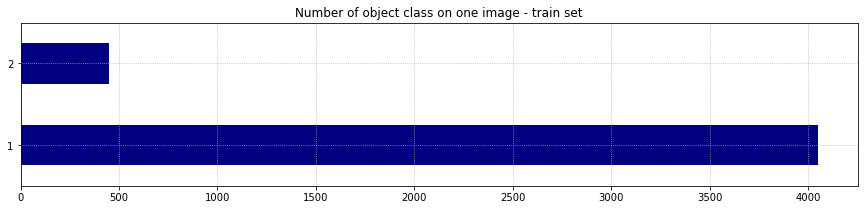

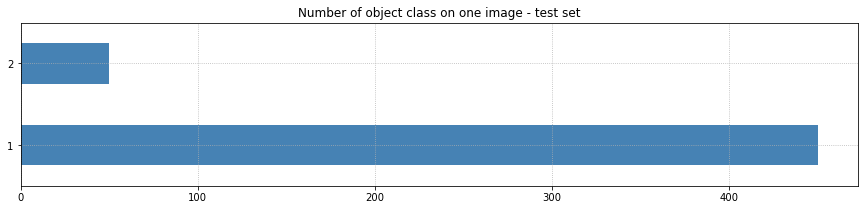

In [35]:
plt.figure(figsize=(15,3))
train_2['num_of_class'].value_counts().plot.barh(color='navy')
plt.grid(ls=':')
plt.title('Number of object class on one image - train set');
plt.figure(figsize=(15,3))
test_2['num_of_class'].value_counts().plot.barh(color='steelblue')
plt.grid(ls=':')
plt.title('Number of object class on one image - test set');

In [36]:
ls_img_train_2 = [int(x) for x in train_2.index]
ls_img_test_2 = [int(x) for x in test_2.index]

In [37]:
tab_obj[tab_obj['no'].isin(ls_img_train_2)].shape, tab_obj[tab_obj['no'].isin(ls_img_test_2)].shape

((22810, 7), (2692, 7))

Intersection of test data sets with three and two classes

In [38]:
len(set.intersection(set(ls_img_train), set(ls_img_train_2))), \
len(set.intersection(set(ls_img_test), set(ls_img_test_2)))

(4061, 61)

In [39]:
ls_set = [ls_img_train, ls_img_train_2, ls_img_test, ls_img_test_2]

In [40]:
with open("ls_set.pkl", "wb") as file:
    dill.dump(ls_set, file)

## Preparing data to SSD model

In [41]:
def annot_xml_to_ls(xml_file):
    """
    Parse the xml - annotation for images into list of dictonary (dict = boundingbox)
    
    _ARGS
    xml_file: str    source of xml file (path) 
    
    _OUTPUTS
    ls_obj:   List   list of dict with information to csv for SSD: 
                     filename, width, height, class, xmin, ymin, xmax, ymax
    """
    ls_obj_tmp = []
    
    with open(xml_file) as fobj:
        xml = fobj.read()

    root = etree.fromstring(xml)
    
    dict_size ={'filename':root.find('filename').text}
    
    for obj in [x for x in root.getchildren() if x.tag == 'size']:
        for child in list(obj):
            if child.tag != 'depth':
                dict_size[child.tag] = int(child.text)
                
    i = 0
    for obj in [x for x in root.getchildren() if x.tag == 'object']:
        for child in list(obj):

            if child.tag == 'name':
                lbl = child.text
                dict_box = {'class':lbl}

            if child.tag == 'bndbox':
                for elem in child:
                    dict_box[elem.tag] = int(elem.text)

        ls_obj_tmp.append({**dict_size, **dict_box})
        i += 1
        
    return ls_obj_tmp


def generate_csv_file(path_to_src_xml, path_to_output_csv, ls_img_no, ls_class, 
                      csv_filename = 'annotation.csv'):
    """
    Bulid csv file from xml in the SSD manner
    
    _ARGS
    path_to_src_xml:    str      path of xmls' source
    path_to_output_csv: str      destination path to save the csv file 
    ls_img_no:          List     list of numbers of images
    ls_class:           List     list of object class (int) 
    csv_filename:       str      default:'annotation.csv'; name of csv file
    
    _OUTPUTS
    saving csv file in destination path
    """
    ls_obj = []
    for no_xml in ls_img_no:
        ls_x = annot_xml_to_ls(os.path.join(path_to_src_xml, 'hard_hat_workers'+str(no_xml)+'.xml'))
        ls_obj.extend(ls_x)
        
    xml_df = pd.DataFrame(ls_obj)
    xml_df = xml_df[xml_df['class'].isin(ls_class)]
    xml_df.to_csv(os.path.join(path_to_output_csv, csv_filename), index=None)
    
    print('Done saving annotations!')

In [42]:
# train
generate_csv_file(path_to_src_xml = annots_path,
                  path_to_output_csv = os.path.join(model_folder, 'train'),
                  ls_img_no = ls_img_train, 
                  ls_class = ['head', 'helmet', 'person'], 
                  csv_filename = 'train_annotation.csv')

generate_csv_file(path_to_src_xml = annots_path,
                  path_to_output_csv = os.path.join(model_folder, 'train_2'),
                  ls_img_no = ls_img_train_2, 
                  ls_class = ['head', 'helmet'], 
                  csv_filename = 'train_annotation.csv')

Done saving annotations!
Done saving annotations!


In [43]:
# test
generate_csv_file(path_to_src_xml = annots_path,
                  path_to_output_csv = os.path.join(model_folder, 'test'),
                  ls_img_no = ls_img_test, 
                  ls_class = ['head', 'helmet', 'person'], 
                  csv_filename = 'test_annotation.csv')

generate_csv_file(path_to_src_xml = annots_path,
                  path_to_output_csv = os.path.join(model_folder, 'test_2'),
                  ls_img_no = ls_img_test_2, 
                  ls_class = ['head', 'helmet'], 
                  csv_filename = 'test_annotation.csv')

Done saving annotations!
Done saving annotations!


## Preparing data to YOLOv3 model

In [44]:
def annot_xml_to_dict(img_src_dir, xml_file):
    """
    Parse the xml - annotation for images into list of dictonary (dict = boundingbox)
    
    _ARGS
    img_src_dir: str source of img (path to dir)
    xml_file: str    source of xml file (path) 
    
    _OUTPUTS
    dict_obj:   dict dict with information to txt for YOLOv3: 
                     dir/filename: [(xmin, ymin, xmax, ymax, class), (xmin, ymin, xmax, ymax, class)]
    """
    with open(xml_file) as fobj:
        xml = fobj.read()

    root = etree.fromstring(xml)

    img_dir = img_src_dir 
    img_name = root.find('filename').text
    dict_key = img_dir+img_name
    
    dict_val = []
    dict_class = {'head':0, 'helmet':1, 'person':2}

    i = 0
    for obj in [x for x in root.getchildren() if x.tag == 'object']:
        for child in list(obj):

            if child.tag == 'name':
                lbl = dict_class[child.text]

            if child.tag == 'bndbox':
                bnd = tuple(int(elem.text) for elem in child)

        dict_val.append((*bnd, lbl))
        i += 1
        
    return dict_key, dict_val


def generate_txt_file(path_to_src_xml, path_to_src_img, path_to_output_txt, ls_img_no, ls_class,
                      txt_filename = 'annotation.txt'):
    """
    Bulid txt file from xml in the YOLOv3 manner
    
    _ARGS
    path_to_src_xml:    str      path of xmls' source
    path_to_src_img     str      path of images' source
    path_to_output_txt: str      destination path to save the csv file 
    ls_img_no:          List     list of numbers of images
    ls_class:           List     list of object class (int) 
    txt_filename:       str      default:'annotation.txt'; name of output txt file
    
    _OUTPUTS
    saving txt file in destination path
    """
    path_to_save_annotations =  os.path.join(path_to_output_txt, txt_filename)
    with open(path_to_save_annotations, 'a+') as f:
        
        for no_xml in ls_img_no:
            file_name, detections = annot_xml_to_dict(img_src_dir = path_to_src_img, 
                                                      xml_file = os.path.join(path_to_src_xml,\
                                                                              'hard_hat_workers'+str(no_xml)+'.xml'))
            
            # save detections in the new annotations file
            f.write(f'{file_name} ')
            
            for detection in detections:
                xmin, ymin, xmax, ymax, c = detection
                if c in ls_class:
                    f.write(f'{xmin},{ymin},{xmax},{ymax},{c} ')

            f.write('\n')

    print('Done saving annotations!')

In [45]:
# train
path_to_txt_file = os.path.join(model_folder, 'train')
generate_txt_file(path_to_src_xml = annots_path,
                  path_to_src_img = '/YOLOv3/data/images/train/',
                  path_to_output_txt = path_to_txt_file, 
                  ls_img_no = ls_img_train,
                  ls_class = [0, 1, 2], 
                  txt_filename = 'train_annotation.txt')

path_to_txt_file = os.path.join(model_folder, 'train_2')
generate_txt_file(path_to_src_xml = annots_path,
                  path_to_src_img = '/YOLOv3/data/images/train/',
                  path_to_output_txt = path_to_txt_file, 
                  ls_img_no = ls_img_train_2,
                  ls_class = [0, 1],
                  txt_filename = 'train_annotation.txt')

Done saving annotations!
Done saving annotations!


In [46]:
# test
path_to_txt_file = os.path.join(model_folder, 'test')
generate_txt_file(path_to_src_xml = annots_path,
                  path_to_src_img = '/YOLOv3/data/images/test/',
                  path_to_output_txt = path_to_txt_file, 
                  ls_img_no = ls_img_test,
                  ls_class = [0, 1, 2],
                  txt_filename = 'test_annotation.txt')

path_to_txt_file = os.path.join(model_folder, 'test_2')
generate_txt_file(path_to_src_xml = annots_path,
                  path_to_src_img = '/YOLOv3/data/images/test/',
                  path_to_output_txt = path_to_txt_file, 
                  ls_img_no = ls_img_test_2,
                  ls_class = [0, 1, ],
                  txt_filename = 'test_annotation.txt')

Done saving annotations!
Done saving annotations!


## Train and test folders creation

In [47]:
#train
dir_dst = os.path.join(model_folder, 'train/images')
for no_xml in ls_img_train:
    filename = 'hard_hat_workers'+str(no_xml)+'.png'
    shutil.copy(os.path.join(images_path, filename), dir_dst)
    
dir_dst = os.path.join(model_folder, 'train_2/images')
for no_xml in ls_img_train_2:
    filename = 'hard_hat_workers'+str(no_xml)+'.png'
    shutil.copy(os.path.join(images_path, filename), dir_dst)

In [48]:
#test
dir_dst = os.path.join(model_folder, 'test/images')
for no_xml in ls_img_test:
    filename = 'hard_hat_workers'+str(no_xml)+'.png'
    shutil.copy(os.path.join(images_path, filename), dir_dst)

dir_dst = os.path.join(model_folder, 'test_2/images')
for no_xml in ls_img_test_2:
    filename = 'hard_hat_workers'+str(no_xml)+'.png'
    shutil.copy(os.path.join(images_path, filename), dir_dst)

## *record* file preparation

SSD model needs the data in TFRecord form, which is a Tensorflow format used for storing a sequence of binary records. It's composed of the following elements:

- images

- label map (label_map.pbtxt)

- annotation in CSV file (output of function *generate_csv_file*)

The script *generate_tfrecord.py* reads the CSV generated previously and label map file - both generated previously, as well as all the images from a given directory and generates a TFRecord file, which can be used later to train an object detection model with TensorFlow. TFRecord file size is the same as the size of all the original images that were included in it. The script is to be called in a terminal.

source https://github.com/abdelrahman-gaber/tf2-object-detection-api-tutorial/blob/master/data_gen/generate_tfrecord.py